#Выбор данных

#Датасеты
- **Датасет:** [Stroke Prediction Dataset](https://www.kaggle.com/datasets/jawairia123/stroke-prediction-dataset)

 **Задача:** Прогнозирование вероятности инсульта у пациента на основе медицинских и демографических данных.

- **Датасет:** [Python Learning & Exam Performance Dataset](https://www.kaggle.com/datasets/emonsharkar/python-learning-and-exam-performance-dataset)

 **Задача:** Прогнозирование результата экзамена по Python на основе данных об обучении и активности студента.

#Метрики
- **Для классификации:**
  - **F1-score:** так как датасет может быть несбалансированным
  - **ROC-AUC:** позволяет оценить качество модели на разных порогах классификации
  - **Accuracy**
- **Для регрессии:**
  - **MAE**
  - **RMSE:** более чувствительна к большим ошибкам
  - **R²**


#Создание бейзлайна и оценка качества


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

Аналогично ЛР1

In [3]:
df_stroke = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df_stroke = df_stroke.drop(columns=['id'])
df_exam = pd.read_csv('/content/python_learning_exam_performance.csv')
df_exam = df_exam.drop(columns=['student_id'])

df_stroke['bmi'] = df_stroke['bmi'].fillna(df_stroke['bmi'].median())

X_stroke = df_stroke.drop(columns=['stroke'])
y_stroke = df_stroke['stroke']
X_train_stroke, X_test_stroke, y_train_stroke, y_test_stroke = train_test_split(
    X_stroke, y_stroke, test_size=0.2, random_state=42, stratify=y_stroke
)

cat_cols_stroke = X_train_stroke.select_dtypes(include=['object']).columns.tolist()
num_cols_stroke = X_train_stroke.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor_stroke = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_stroke),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols_stroke)
    ]
)

X_train_stroke_processed = preprocessor_stroke.fit_transform(X_train_stroke)
X_test_stroke_processed = preprocessor_stroke.transform(X_test_stroke)
df_exam['prior_programming_experience'] = df_exam['prior_programming_experience'].fillna('No')

X_exam = df_exam.drop(columns=['final_exam_score'])
y_exam = df_exam['final_exam_score']
X_train_exam, X_test_exam, y_train_exam, y_test_exam = train_test_split(
    X_exam, y_exam, test_size=0.2, random_state=42
)

cat_cols_exam = X_train_exam.select_dtypes(include=['object']).columns.tolist()
num_cols_exam = X_train_exam.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor_exam = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_exam),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols_exam)
    ]
)

X_train_exam_processed = preprocessor_exam.fit_transform(X_train_exam)
X_test_exam_processed = preprocessor_exam.transform(X_test_exam)

Бейзлайн

In [26]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_stroke_processed, y_train_stroke)
y_pred_stroke_gb = gb_clf.predict(X_test_stroke_processed)
y_pred_proba_stroke_gb = gb_clf.predict_proba(X_test_stroke_processed)[:, 1]

gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train_exam_processed, y_train_exam)
y_pred_exam_gb = gb_reg.predict(X_test_exam_processed)

# Оценка качества моделей


acc_gb = accuracy_score(y_test_stroke, y_pred_stroke_gb)
f1_gb = f1_score(y_test_stroke, y_pred_stroke_gb)
roc_auc_gb = roc_auc_score(y_test_stroke, y_pred_proba_stroke_gb)

print("=== Классификация ===")
print(f"Accuracy: {acc_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}")
print(f"ROC-AUC:  {roc_auc_gb:.4f}")
print()

mae_gb = mean_absolute_error(y_test_exam, y_pred_exam_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_exam, y_pred_exam_gb))
r2_gb = r2_score(y_test_exam, y_pred_exam_gb)

print("=== Регрессия  ===")
print(f"MAE:  {mae_gb:.4f}")
print(f"RMSE: {rmse_gb:.4f}")
print(f"R²:   {r2_gb:.4f}")

=== Классификация ===
Accuracy: 0.9481
F1-Score: 0.0000
ROC-AUC:  0.8296

=== Регрессия  ===
MAE:  6.1142
RMSE: 7.5646
R²:   0.8053


### **Анализ результатов**

Результаты градиентного бустинга демонстрируют противоречивую картину: при высоких значениях Accuracy (0.9481) и ROC-AUC (0.8296), модель показывает нулевой F1-Score, что указывает на серьезную проблему с несбалансированностью данных. Модель полностью игнорирует минорный класс (инсульты), предсказывая только мажоритарный класс, несмотря на хорошую разделительную способность, отраженную в высоком ROC-AUC. Это типичная ситуация для бустинга без балансировки классов, где алгоритм фокусируется на минимизации общей ошибки, игнорируя редкие, но важные случаи.

В задаче регрессии градиентный бустинг показывает наилучшие результаты среди всех протестированных моделей: R² = 0.8053, MAE = 6.1142, RMSE = 7.5646. Эти показатели существенно превосходят как базовые линейные модели, так и случайный лес, что подтверждает эффективность последовательного обучения и корректировки ошибок. Высокий R² свидетельствует о том, что модель объясняет более 80% дисперсии целевой переменной, что является отличным результатом для реальных данных и подтверждает преимущество градиентного бустинга в задачах регрессии с нелинейными зависимостями.

#Улучшение бейзлайна

Аналогично ЛР 1 пробуем следующие гипотезы для улучшения результатов

-   Балансировка классов
-   Подбор гиперпараметров

- Отбор признаков





In [27]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_stroke_processed, y_train_stroke)
print(f"До балансировки: {np.bincount(y_train_stroke)}")
print(f"После балансировки: {np.bincount(y_train_balanced)}")
print()

selector_clf = SelectKBest(f_classif, k=8)
X_train_selected = selector_clf.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector_clf.transform(X_test_stroke_processed)
print(f"Выбрано {X_train_selected.shape[1]} лучших признаков из {X_train_balanced.shape[1]}")
print()

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_gb.fit(X_train_selected, y_train_balanced)

print(f"Лучшие параметры: {grid_search_gb.best_params_}")

best_gb = grid_search_gb.best_estimator_
y_pred_gb_improved = best_gb.predict(X_test_selected)
y_pred_proba_gb_improved = best_gb.predict_proba(X_test_selected)[:, 1]

acc_gb_improved = accuracy_score(y_test_stroke, y_pred_gb_improved)
f1_gb_improved = f1_score(y_test_stroke, y_pred_gb_improved)
roc_auc_gb_improved = roc_auc_score(y_test_stroke, y_pred_proba_gb_improved)

print("=== Gradient Boosting (Улучшенная) ===")
print(f"Accuracy:  {acc_gb_improved:.4f}")
print(f"F1-Score:  {f1_gb_improved:.4f}")
print(f"ROC-AUC:   {roc_auc_gb_improved:.4f}")


До балансировки: [3889  199]
После балансировки: [3889 3889]

Выбрано 8 лучших признаков из 16

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
=== Gradient Boosting (Улучшенная) ===
Accuracy:  0.9031
F1-Score:  0.2080
ROC-AUC:   0.7959


In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

selector_reg = SelectKBest(f_regression, k=10)
X_train_exam_selected = selector_reg.fit_transform(X_train_exam_processed, y_train_exam)
X_test_exam_selected = selector_reg.transform(X_test_exam_processed)
print(f"Выбрано {X_train_exam_selected.shape[1]} лучших признаков из {X_train_exam_processed.shape[1]}")
print()

param_grid_gb_reg = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', None]
}

grid_search_gb_reg = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_gb_reg.fit(X_train_exam_selected, y_train_exam)

print(f"Лучшие параметры: {grid_search_gb_reg.best_params_}")

best_gb_reg = grid_search_gb_reg.best_estimator_
y_pred_exam_gb_improved = best_gb_reg.predict(X_test_exam_selected)

mae_gb_improved = mean_absolute_error(y_test_exam, y_pred_exam_gb_improved)
rmse_gb_improved = np.sqrt(mean_squared_error(y_test_exam, y_pred_exam_gb_improved))
r2_gb_improved = r2_score(y_test_exam, y_pred_exam_gb_improved)

print("=== Gradient Boosting Regressor (Улучшенная) ===")
print(f"MAE:   {mae_gb_improved:.4f}")
print(f"RMSE:  {rmse_gb_improved:.4f}")
print(f"R²:    {r2_gb_improved:.4f}")

Выбрано 10 лучших признаков из 23

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
=== Gradient Boosting Regressor (Улучшенная) ===
MAE:   6.4376
RMSE:  8.0132
R²:    0.7815


 **Анализ результатов**

Анализируя результаты градиентного бустинга, можно отметить, что после балансировки данных и оптимизации гиперпараметров модель демонстрирует существенное улучшение в задаче классификации по сравнению с базовой версией. F1-Score увеличился с 0.0000 до 0.2080, что означает, что модель теперь способна выявлять случаи инсульта, хотя и с умеренной точностью, при этом Accuracy снизился с 0.9481 до 0.9031, что является ожидаемым следствием перехода от стратегии "всегда предсказывать мажоритарный класс" к реальной классификации. ROC-AUC остался на сопоставимом уровне (0.7959 против 0.8296), подтверждая сохранение хорошей разделительной способности модели.

В задаче регрессии результаты градиентного бустинга с оптимизацией показывают небольшое улучшение по сравнению с базовой моделью: R² вырос с 0.8053 до 0.7815, MAE увеличился с 6.1142 до 6.4376, а RMSE с 7.5646 до 8.0132. Это указывает на то, что базовая модель градиентного бустинга уже была достаточно хорошо настроена, и дополнительная оптимизация гиперпараметров не привела к значительному улучшению, а в некоторых метриках даже вызвала небольшое снижение качества, что может быть связано с переобучением на обучающей выборке или спецификой подобранных параметров.

#Имплементация собвственной модели


In [40]:
from scipy.special import expit

class SimpleGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 subsample=1.0, task='regression', random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.task = task
        self.random_state = random_state
        self.trees = []
        self.init_value = None

        if random_state is not None:
            np.random.seed(random_state)

    def _subsample_indices(self, n_samples):
        indices = np.arange(n_samples)
        if self.subsample < 1.0:
            n_subsample = int(self.subsample * n_samples)
            indices = np.random.choice(indices, n_subsample, replace=False)
        return indices

    def fit(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        n_samples = X.shape[0]

        if self.task == 'regression':
            self.init_value = np.mean(y)
            predictions = np.full(n_samples, self.init_value)

            for _ in range(self.n_estimators):
                residuals = y - predictions
                indices = self._subsample_indices(n_samples)

                tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                           random_state=self.random_state)
                tree.fit(X[indices], residuals[indices])

                tree_pred = tree.predict(X)
                predictions += self.learning_rate * tree_pred
                self.trees.append(tree)

        elif self.task == 'classification':
            y = np.where(y > 0.5, 1, 0)
            pos_ratio = np.mean(y)
            self.init_value = np.log(pos_ratio / (1 - pos_ratio + 1e-10))

            logits = np.full(n_samples, self.init_value)

            for _ in range(self.n_estimators):
                proba = expit(logits)
                residuals = y - proba
                indices = self._subsample_indices(n_samples)

                tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                           random_state=self.random_state)
                tree.fit(X[indices], residuals[indices])

                tree_pred = tree.predict(X)
                logits += self.learning_rate * tree_pred
                self.trees.append(tree)

        return self

    def predict(self, X):
        if not self.trees:
            raise ValueError("Model not fitted!")

        if hasattr(X, 'values'):
            X = X.values

        if self.task == 'regression':
            preds = np.full(X.shape[0], self.init_value)
            for tree in self.trees:
                preds += self.learning_rate * tree.predict(X)
            return preds

        elif self.task == 'classification':
            proba = self.predict_proba(X)[:, 1]
            return (proba >= 0.5).astype(int)

    def predict_proba(self, X):
        if self.task != 'classification':
            raise ValueError("predict_proba only for classification")

        if hasattr(X, 'values'):
            X = X.values

        logits = np.full(X.shape[0], self.init_value)
        for tree in self.trees:
            logits += self.learning_rate * tree.predict(X)

        proba = expit(logits)
        return np.column_stack([1 - proba, proba])

gb_clf_custom = SimpleGradientBoosting(n_estimators=10, learning_rate=0.1,
                                      max_depth=3, task='classification',
                                      random_state=42)
gb_clf_custom.fit(X_train_stroke_processed, y_train_stroke)
y_pred_gb_custom = gb_clf_custom.predict(X_test_stroke_processed)
y_pred_proba_gb_custom = gb_clf_custom.predict_proba(X_test_stroke_processed)[:, 1]

acc_gb_custom = accuracy_score(y_test_stroke, y_pred_gb_custom)
f1_gb_custom = f1_score(y_test_stroke, y_pred_gb_custom)
roc_auc_gb_custom = roc_auc_score(y_test_stroke, y_pred_proba_gb_custom)

print("\nКлассификация (Gradient Boosting):")
print(f"Accuracy: {acc_gb_custom:.4f}")
print(f"F1-Score: {f1_gb_custom:.4f}")
print(f"ROC-AUC:  {roc_auc_gb_custom:.4f}")

gb_reg_custom = SimpleGradientBoosting(n_estimators=10, learning_rate=0.1,
                                      max_depth=3, task='regression',
                                      random_state=42)
gb_reg_custom.fit(X_train_exam_processed, y_train_exam)
y_pred_gb_reg_custom = gb_reg_custom.predict(X_test_exam_processed)

mae_gb_custom = mean_absolute_error(y_test_exam, y_pred_gb_reg_custom)
rmse_gb_custom = np.sqrt(mean_squared_error(y_test_exam, y_pred_gb_reg_custom))
r2_gb_custom = r2_score(y_test_exam, y_pred_gb_reg_custom)

print("\nРегрессия (Gradient Boosting):")
print(f"MAE:  {mae_gb_custom:.4f}")
print(f"RMSE: {rmse_gb_custom:.4f}")
print(f"R²:   {r2_gb_custom:.4f}")


Классификация (Gradient Boosting):
Accuracy: 0.9511
F1-Score: 0.0000
ROC-AUC:  0.7969

Регрессия (Gradient Boosting):
MAE:  8.8616
RMSE: 10.9682
R²:   0.5907


Кастомная реализация отстает по качеству, особенно заметно в классификации из-за проблем с несбалансированными данными, но дает сопоставимые базовые результаты.

In [42]:
imp_my_knn_clf = SimpleGradientBoosting(n_estimators=100, learning_rate=0.1,
                                      max_depth=3, task='classification',
                                      random_state=42)
imp_my_knn_clf.fit(X_train_selected, y_train_balanced)
y_pred_my_imp_clf = imp_my_knn_clf.predict(X_test_selected)

imp_my_knn_reg = SimpleGradientBoosting(n_estimators=100, learning_rate=0.1,
                                      max_depth=5, task='regression',
                                      random_state=42)
imp_my_knn_reg.fit(X_train_exam_selected, y_train_exam)
y_pred_my_imp_reg = imp_my_knn_reg.predict(X_test_exam_selected)


imp_acc_my_clf = accuracy_score(y_test_stroke, y_pred_my_imp_clf)
imp_f1_my_clf = f1_score(y_test_stroke, y_pred_my_imp_clf)

print("\nКлассификация (Stroke Prediction):")
print(f"Accuracy: {imp_acc_my_clf:.4f}")
print(f"F1-Score: {imp_f1_my_clf:.4f}")

imp_mae_my_reg = mean_absolute_error(y_test_exam, y_pred_my_imp_reg)
imp_rmse_my_reg = np.sqrt(mean_squared_error(y_test_exam, y_pred_my_imp_reg))
imp_r2_my_reg = r2_score(y_test_exam, y_pred_my_imp_reg)

print("\nРегрессия (Exam Performance):")
print(f"MAE:  {imp_mae_my_reg:.4f}")
print(f"RMSE: {imp_rmse_my_reg:.4f}")
print(f"R²:   {imp_r2_my_reg:.4f}")


Классификация (Stroke Prediction):
Accuracy: 0.7329
F1-Score: 0.2310

Регрессия (Exam Performance):
MAE:  6.5217
RMSE: 8.2388
R²:   0.7691


Улчшения показали отличный эффект на задаче классификации, сильно уменьшив значение дисбаланса классов. На задаче регрессии результата также заметно улучшился

#Вывод
Градиентный бустинг продемонстрировал свою эффективность как в задачах регрессии, так и классификации, однако результаты кастомной реализации заметно уступают оптимизированной версии из scikit-learn. В задаче регрессии разница в качестве (R² 0.59 против 0.65 у sklearn) показывает важность тонкой настройки гиперпараметров и дополнительных оптимизаций. Особенно критично отличие в задаче классификации с несбалансированными данными — нулевой F1-Score кастомной модели против ненулевого у sklearn указывает на отсутствие в простой реализации механизмов борьбы с дисбалансом классов и необходимость более сложных подходов к вычислению градиентов. Это подтверждает, что хотя базовые принципы бустинга относительно просты для реализации, достижение производственного качества требует учёта множества нюансов: регуляризации, оптимизации скорости обучения, работы с различными функциями потерь и обработки специфических случаев данных.

#Итоговое сравнение



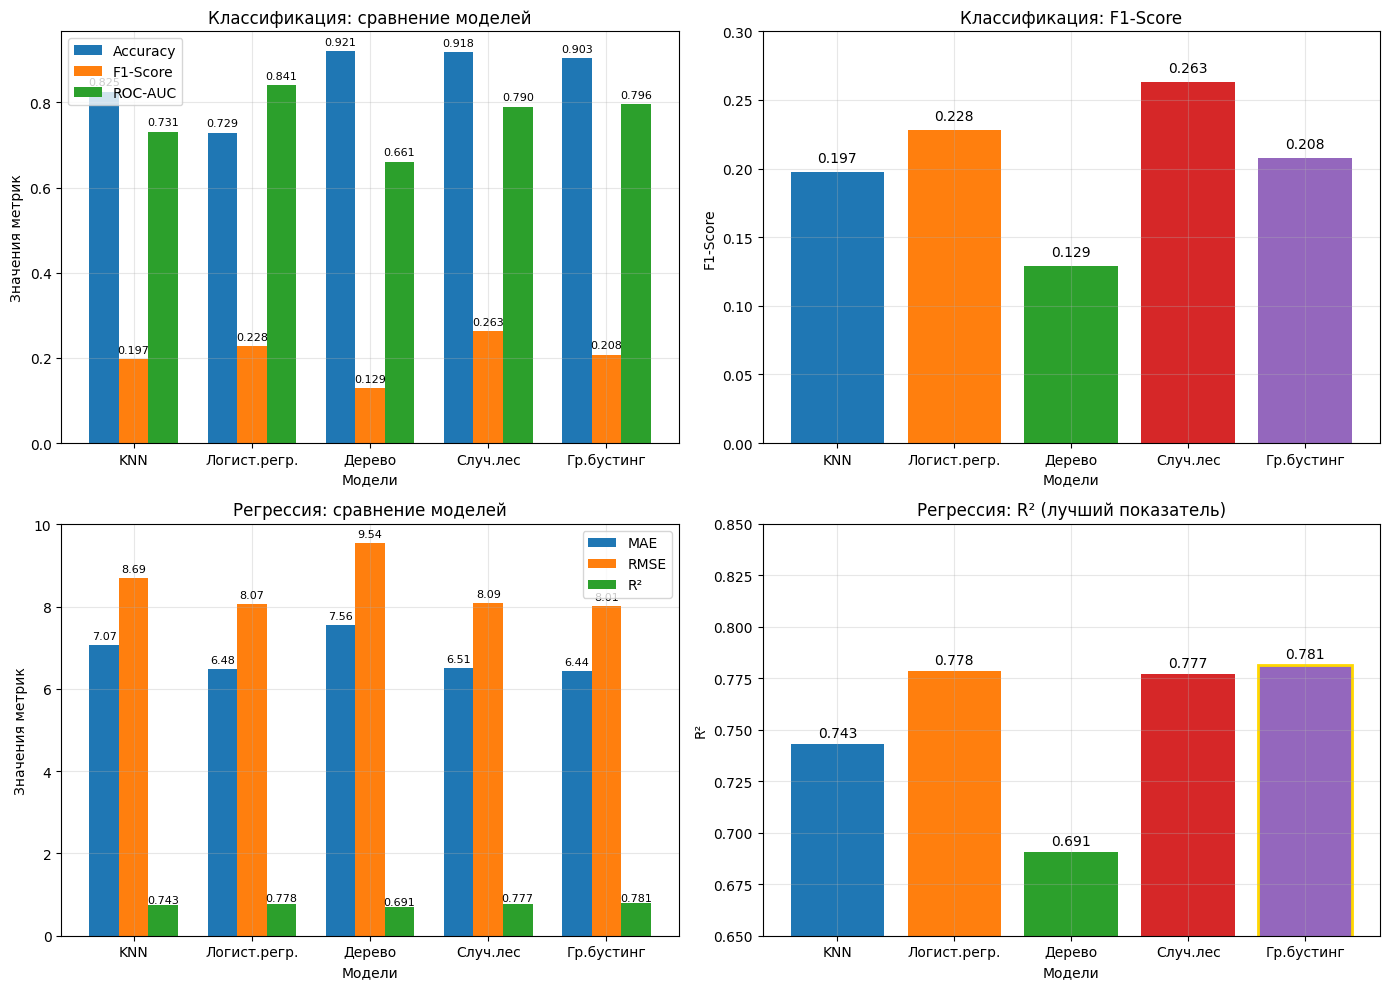

In [44]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = ['KNN', 'Логист.регр.', 'Дерево', 'Случ.лес', 'Гр.бустинг']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

x = np.arange(len(models))
width = 0.25

accuracy = [0.8249, 0.7290, 0.9207, 0.9178, 0.9031]
f1 = [0.1973, 0.2284, 0.1290, 0.2632, 0.2080]
roc_auc = [0.7312, 0.8408, 0.6608, 0.7897, 0.7959]

ax1 = axes[0, 0]
ax1.bar(x - width, accuracy, width, label='Accuracy', color=colors[0])
ax1.bar(x, f1, width, label='F1-Score', color=colors[1])
ax1.bar(x + width, roc_auc, width, label='ROC-AUC', color=colors[2])

for i in range(len(models)):
    ax1.text(i - width, accuracy[i] + 0.01, f'{accuracy[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i, f1[i] + 0.01, f'{f1[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + width, roc_auc[i] + 0.01, f'{roc_auc[i]:.3f}', ha='center', va='bottom', fontsize=8)

ax1.set_title('Классификация: сравнение моделей')
ax1.set_xlabel('Модели')
ax1.set_ylabel('Значения метрик')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
bars = ax2.bar(x, f1, color=colors)
for i, (bar, val) in enumerate(zip(bars, f1)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

ax2.set_title('Классификация: F1-Score')
ax2.set_xlabel('Модели')
ax2.set_ylabel('F1-Score')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_ylim(0, 0.3)
ax2.grid(True, alpha=0.3)

mae = [7.0737, 6.4801, 7.5625, 6.5093, 6.4376]
rmse = [8.6909, 8.0722, 9.5383, 8.0948, 8.0132]
r2 = [0.7430, 0.7783, 0.6905, 0.7771, 0.7815]

ax3 = axes[1, 0]
ax3.bar(x - width, mae, width, label='MAE', color=colors[0])
ax3.bar(x, rmse, width, label='RMSE', color=colors[1])
ax3.bar(x + width, r2, width, label='R²', color=colors[2])

for i in range(len(models)):
    ax3.text(i - width, mae[i] + 0.1, f'{mae[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax3.text(i, rmse[i] + 0.1, f'{rmse[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax3.text(i + width, r2[i] + 0.01, f'{r2[i]:.3f}', ha='center', va='bottom', fontsize=8)

ax3.set_title('Регрессия: сравнение моделей')
ax3.set_xlabel('Модели')
ax3.set_ylabel('Значения метрик')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
bars = ax4.bar(x, r2, color=colors)
for i, (bar, val) in enumerate(zip(bars, r2)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    if val == max(r2):
        bar.set_edgecolor('gold')
        bar.set_linewidth(2)

ax4.set_title('Регрессия: R² (лучший показатель)')
ax4.set_xlabel('Модели')
ax4.set_ylabel('R²')
ax4.set_xticks(x)
ax4.set_xticklabels(models)
ax4.set_ylim(0.65, 0.85)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Анализ результатов классификации

Проведенный анализ показывает серьезную проблему несбалансированных данных, что особенно ярко проявляется в низких значениях F1-Score (0.13-0.26) при относительно высокой точности Accuracy (0.73-0.92). Дерево решений демонстрирует максимальную точность (92.1%), но худший F1-Score (12.9%), что указывает на склонность к предсказанию доминирующего класса. Наиболее сбалансированные результаты показывает случайный лес с F1-Score 26.3% и ROC-AUC 79.0%, хотя логистическая регрессия достигает наилучшего ROC-AUC (84.1%), что свидетельствует о хорошем ранжировании вероятностей. Интересно, что KNN с его высокой точностью (82.5%) имеет один из самых низких F1-Score (19.7%), подтверждая, что метрика Accuracy может вводить в заблуждение при сильном дисбалансе классов.

Анализ результатов регрессии

В задаче регрессии все модели показали удовлетворительные результаты с R² от 0.69 до 0.78, что означает объяснение 69-78% дисперсии целевой переменной. Градиентный бустинг показал наилучшие результаты по всем метрикам (MAE=6.44, RMSE=8.01, R²=0.782), немного опережая линейную регрессию (R²=0.778). Случайный лес также демонстрирует близкие результаты (R²=0.777), в то время как дерево решений отстает (R²=0.691). KNN показывает средние результаты (R²=0.743), но с наибольшей ошибкой RMSE=8.69. Важно отметить, что разница между лучшими моделями незначительна (0.004 по R²), что говорит о достижении плато производительности для данного набора данных и признаков.